## Solving UMApHMP with VNS

In [1]:
import sys
from os import listdir
from os.path import isfile, join
import string

import numpy as np
from plot_utils import plot_two_solutions
import matplotlib.pyplot as plt 

from ioutils import parse_input
from utils import get_distance_matrix
from utils import get_discount_matrix
from utils import allocate_paths
from utils import get_nodes
from utils import get_total_cost
from utils import get_flow_from_paths
import cplex_utils
import graph_utils as graph_utils

### Testing allocate_paths

In [2]:
DATASET = 'AP'
INPUT_DIRECTORY = "./data/AP/"

In [3]:
files = [join(INPUT_DIRECTORY, f) for f in listdir(INPUT_DIRECTORY) if isfile(join(INPUT_DIRECTORY, f))]
print(files)
file = files[0]
print(file)

['./data/AP/10.3', './data/AP/20.3', './data/AP/50.3', './data/AP/10.2', './data/AP/ReadMe-UMApHMP.txt', './data/AP/5.3', './data/AP/25.3', './data/AP/10.5', './data/AP/100.3', './data/AP/200.3', './data/AP/10.4', './data/AP/40.3', './data/AP/Solutions-UMApHMP.txt']
./data/AP/10.3


In [4]:
n, p, alpha, delta, ksi, nodes_coordinates, demand = parse_input(file, DATASET)
nodes = get_nodes(n)
distances = get_distance_matrix(nodes_coordinates)

In [5]:
M, X, Y, Z, H = cplex_utils.get_umaphmp_model(n, p, alpha, delta, ksi, distances, demand, formulation='EK', verbose=True)
solution = M.solve(log_output=True)
hubs_bit_mask = [int(solution.get_var_value(H[i])) for i in range(n)]
cplex_objective = round(solution.objective_value, 7)

[2023-07-31 22:20:31,323] Created model M
[2023-07-31 22:20:31,348] Defined variables X
[2023-07-31 22:20:31,372] Defined variables Y
[2023-07-31 22:20:31,375] Defined variables Z
[2023-07-31 22:20:31,376] Defined variables H
[2023-07-31 22:20:31,377] Defined constraints (2)
[2023-07-31 22:20:31,378] Defined constraints (3)
[2023-07-31 22:20:31,387] Defined constraints (4)
[2023-07-31 22:20:31,404] Defined constraints (5)
[2023-07-31 22:20:31,420] Defined constraints (6)
[2023-07-31 22:20:31,438] Defined constraints (7)
[2023-07-31 22:20:31,454] Defined constraints (1)


Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIP Presolve eliminated 0 rows and 100 columns.
Reduced MIP has 411 rows, 2010 columns, and 5310 nonzeros.
Reduced MIP has 10 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.62 ticks)
Found incumbent of value 5.4035881e+08 after 0.01 sec. (3.81 ticks)
Probing time = 0.00 sec. (0.13 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 411 rows, 2010 columns, and 5310 nonzeros.
Reduced MIP has 10 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.04 ticks)
Probing time = 0.00 sec. (0.13 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (4.54 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integ

In [6]:
Z_allocated = {(i,k): solution.get_var_value(Z[i,k]) for i in range(n) for k in range(n)}
X_allocated = {(i,l,j): solution.get_var_value(X[i,l,j]) for i in range(n) for l in range(n) for j in range(n)}
Y_allocated = {(i,k,l): solution.get_var_value(Y[i,k,l]) for i in range(n) for k in range(n) for l in range(n)}
cplex_flow = cplex_utils.get_flow_from_XYZ(n, X_allocated, Y_allocated, Z_allocated)

In [7]:
hubs, = np.where(hubs_bit_mask)
hubs

array([2, 6, 7])

In [8]:
discounts = get_discount_matrix(n, hubs, alpha, delta, ksi)

In [9]:
paths = allocate_paths(n, hubs, distances, discounts)

In [10]:
vns_flow = get_flow_from_paths(n, paths, demand)

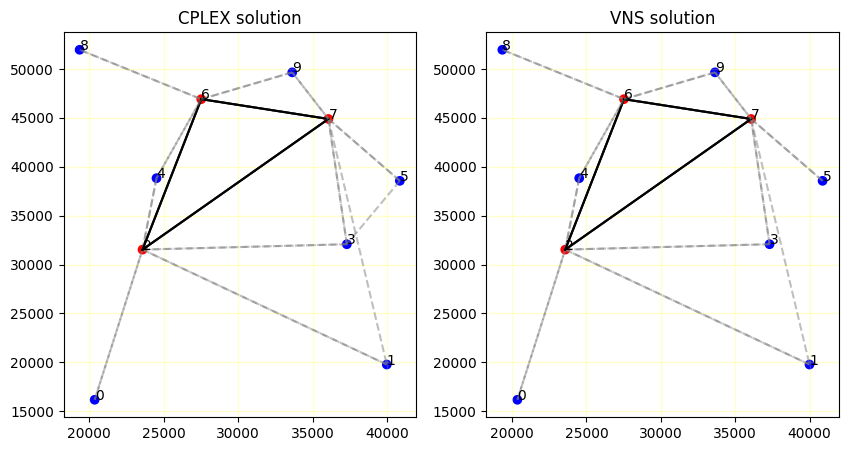

In [11]:
plot_two_solutions(nodes_coordinates, 
                   hubs_bit_mask, 
                   hubs_bit_mask, 
                   cplex_flow, 
                   vns_flow,  
                   title1="CPLEX solution",
                   title2="VNS solution",
                   point_labels='numbers', plot_all_lines=False, verbose=0)

In [12]:
# todo: AP/10.3: why cplex flow (graph on the left) contains non-hub - non-hub edge 3-5 ???
#   because we got some very small non-zero number => we should drop some decimals!
cplex_flow[5,3]

2.2737367544323206e-13

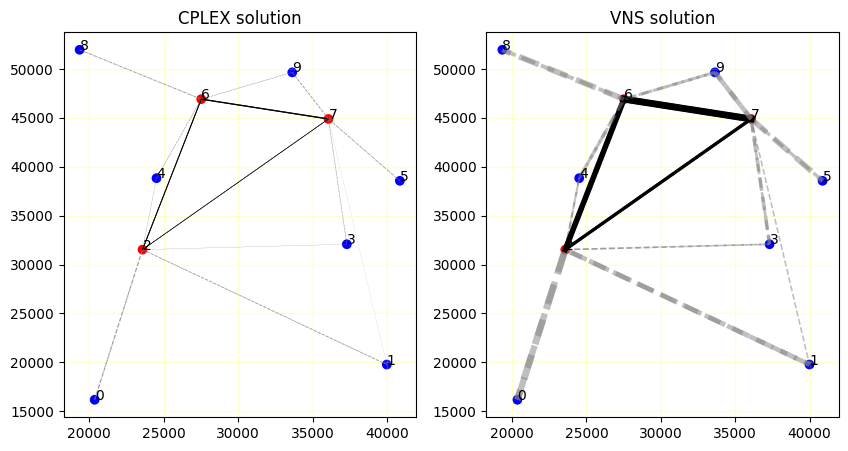

In [13]:
# if I choose that edge tickness represents flow (verbose=2) it's not visible
plot_two_solutions(nodes_coordinates, 
                   hubs_bit_mask, 
                   hubs_bit_mask, 
                   cplex_flow, 
                   vns_flow,  
                   title1="CPLEX solution",
                   title2="VNS solution",
                   point_labels='numbers', plot_all_lines=False, verbose=2)

In [14]:
get_total_cost(vns_flow, distances, discounts)

131581786.946515

In [15]:
get_total_cost(cplex_flow, distances, discounts)

131581786.94651498

In [16]:
cplex_objective

131581786.946515

### Implementing VNS algorithm framework

In [17]:
from vns import basic_VNS

from umaphmp import ProblemInstance
from umaphmp import Solution

from utils  import get_flow_from_hubs

In [18]:
MAX_ITER = 200

#### Testing

In [19]:
files = [join(INPUT_DIRECTORY, f) for f in listdir(INPUT_DIRECTORY) if isfile(join(INPUT_DIRECTORY, f))]
print(files)
file = files[1]
print(file)

['./data/AP/10.3', './data/AP/20.3', './data/AP/50.3', './data/AP/10.2', './data/AP/ReadMe-UMApHMP.txt', './data/AP/5.3', './data/AP/25.3', './data/AP/10.5', './data/AP/100.3', './data/AP/200.3', './data/AP/10.4', './data/AP/40.3', './data/AP/Solutions-UMApHMP.txt']
./data/AP/20.3


In [20]:
n, p, alpha, delta, ksi, node_coordinates, demand = parse_input(file, DATASET)
problem = ProblemInstance(n, p, alpha, delta, ksi, node_coordinates, demand)

In [21]:
vns_solution = basic_VNS(problem, MAX_ITER)

100%|██████████| 200/200 [01:19<00:00,  2.53it/s]


In [22]:
print(vns_solution.hubs)
print(vns_solution.cost)

[13, 5, 11]
148048299.25765765


In [23]:
flow = get_flow_from_hubs(
    vns_solution.hubs, 
    problem.n, 
    problem.alpha, 
    problem.delta, 
    problem.ksi, 
    problem.distances, 
    problem.demand)

In [24]:
from plot_utils import plot_solution
from utils import bitmap

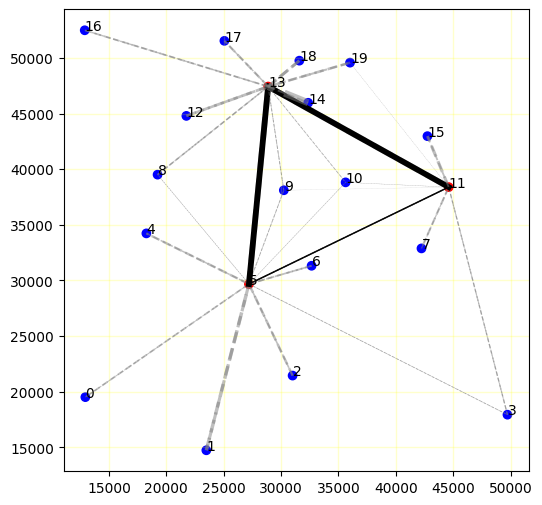

In [25]:
plot_solution(node_coordinates, bitmap(n, vns_solution.hubs), flow, point_labels='numbers', plot_all_lines=False, verbose=2)